## Neural Networks

<a href="https://colab.research.google.com/github/chattopadhyayA/ml_pursue2025/blob/master/content/06_NN_basic.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Implementation

There are several popular python packages for implementing neural networks like **Tensorflow**, **Pytorch** etc. In this course we will only focus on **Pytorch**. In all the packages, the core ideas remains the same

1. **Feed-Forward**
    - For each layer the input $a$ ($a=x$ for the first layer) is multiplied by weights $W$, added to biases $b$, then passed through as activation function $f$. Therefore, for the $l^{th}$ layer and $i^{th}$ neuron we have the output
  
    $$
    z^{l}_i = \sum_{j=1}^{h_l} f(w^{(l,l-1)}_{ij}z^{l-1}_j+b_{i}^{l})
    $$

    where $h_l$ is the number of hidden nodes at the $l^{th}$ layer. Note that here we are using $h_0=len(x)$.
    - Note that here the network/model parameters $\theta$ includes all weights and biases as a whole.
    - Output propagates from input layer through hidden layers to the output.

2. **Back-Propagation**
    - Compute loss $\mathcal{L}(\hat{y},y;\theta)$ where $\hat{y}$ is the network output and $y$ is the true output.
    - Use the chain rule to compute $\frac{\partial \mathcal{L}}{\partial W_{ij}^{(l,l-1)}}$ and $\frac{\partial \mathcal{L}}{\partial b_i^{l}}$ for each layer $l$, propagating the error backward.

3. **Gradient Descent**
    - Update each parameter $\theta \in {w,b}$ by
    $$
    \theta \leftarrow \theta - \alpha \frac{\partial \mathcal{L}}{\partial \theta}
    $$
    where $\alpha$ is the learning rate.


### Using PyTorch

We will now learn implementing the above steps in PyTorch by fitting a simple dataset where 
$$
y= 0.1 x^3 - 0.5 x^2 + 2 \sin(3x),\quad x \in [-2,2]
$$
First we plot the “ground truth” curve we want our network to learn. No noise—this is a deterministic regression task.
Then we convert our *NumPy* arrays into PyTorch tensors and wrap them in a **DataLoader** so we can batch them during training.

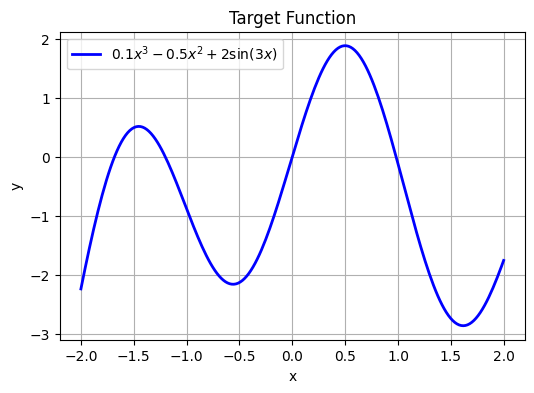

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 200 points in [-2,2]
X_np = np.linspace(-2, 2, 200).reshape(-1,1)
# Define f(x) = 0.1 x^3 - 0.5 x^2 + 2 sin(3x)
Y_np = 0.1*X_np**3 - 0.5*X_np**2 + 2*np.sin(3*X_np)

# Plot the true function
plt.figure(figsize=(6,4))
plt.plot(X_np, Y_np, 'b-', linewidth=2,
         label=r'$0.1x^3 -0.5x^2 +2\sin(3x)$')
plt.xlabel('x'); plt.ylabel('y')
plt.title('Target Function')
plt.legend(); plt.grid(True)
plt.show()



In [2]:
# Convert to PyTorch tensors & DataLoader

import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to float32 tensors
X = torch.from_numpy(X_np).float()  # shape (200,1)
Y = torch.from_numpy(Y_np).float()  # shape (200,1)

# Create a 80/20 train/validation split
dataset = TensorDataset(X, Y)
val_size   = int(0.2 * len(dataset))
train_set, val_set = torch.utils.data.random_split(
    dataset, [len(dataset)-val_size, val_size]
)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=32)


#### Defining the Model

We define a simple feed‐forward network SimpleNet with one hidden layer of size $32$ and *ReLU* activation.

In [3]:
import torch.nn as nn

class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)


We must choose a learning rate, decide how many epochs to train, and pick an optimizer. We’ll use plain stochastic gradient descent (SGD) here, but you can swap in Adam or others.

In [4]:
# Hyper-parameters
learning_rate = 1e-2
num_epochs    = 100


For regression, we commonly use mean squared error (MSE). We instantiate nn.MSELoss(). For parameter updates, we pass our model’s parameters and the learning rate to an optimizer, here **torch.optim.SGD**.

In [5]:
model     = SimpleNet()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


Each epoch, we iterate over mini-batches from our DataLoader. For each batch we:

1. Zero out any stored gradients.

2. Run a forward pass to compute predictions.

3. Compute loss against true y.

4. Call loss.backward() to back-propagate gradients.

5. Call optimizer.step() to update weights.

We’ll also track and plot training vs. validation loss for diagnosing over-/under-fitting. To illustrate everything together, we create a helper train_and_plot that takes any model instance, trains it for a given number of epochs and learning rate, then plots:

1. Training loss curve

2. Final prediction curve vs noisy data and true $\sin(x)$.

In [6]:
def train_and_evaluate(model, epochs, lr, early_stop=False, patience=5):
    """
    Trains `model` for up to `epochs` with LR `lr`.
    If `early_stop=True`, monitors validation loss and stops after `patience` non-improving epochs.
    Always reloads the best model before plotting.
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    best_val = float('inf')
    best_epoch = 0
    wait = 0

    for epoch in range(1, epochs + 1):
        # — Training —
        model.train()
        running_train = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            running_train += loss.item() * xb.size(0)
        train_losses.append(running_train / len(train_loader.dataset))

        # — Validation —
        model.eval()
        running_val = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                running_val += criterion(model(xb), yb).item() * xb.size(0)
        val_loss = running_val / len(val_loader.dataset)
        val_losses.append(val_loss)

        # — Check for improvement —
        if val_loss < best_val:
            best_val = val_loss
            best_epoch = epoch
            wait = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            wait += 1
            if early_stop and wait >= patience:
                print(f"→ Early stopping at epoch {epoch} (best at {best_epoch})")
                break

    # Reload the best‐seen weights
    model.load_state_dict(torch.load('best_model.pt'))

    # — Plot Loss Curves —
    plt.figure(figsize=(6,3))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses,   label='Val   Loss')
    if early_stop:
        plt.axvline(best_epoch, color='red', linestyle='--',
                    label=f'Best Epoch {best_epoch}')
    plt.title('Loss Curves')
    plt.xlabel('Epoch'); plt.ylabel('MSE')
    plt.legend(); plt.grid(True)
    plt.show()

    # — Plot Final Fit —
    with torch.no_grad():
        preds = model(X).numpy()
    plt.figure(figsize=(6,4))
    plt.scatter(X_np, Y_np, s=10, label='True samples')
    plt.plot(X_np, preds, 'r-', label='Model prediction')
    plt.xlabel('x'); plt.ylabel('y')
    plt.title('Final Model Fit')
    plt.legend(); plt.grid(True)
    plt.show()

    #return best_epoch


#### Over-fitting vs Under-fitting
- **Under-fitting** occurs when both training and validation error remain high-- *your model is too simple*.

- **Over-fitting** occurs when training error is low but validation error rises —- *your model is too complex or trained too long*.

##### Illustrating Under-fitting

Train with only 5 epochs—the network hasn’t had enough time to capture the sine pattern.

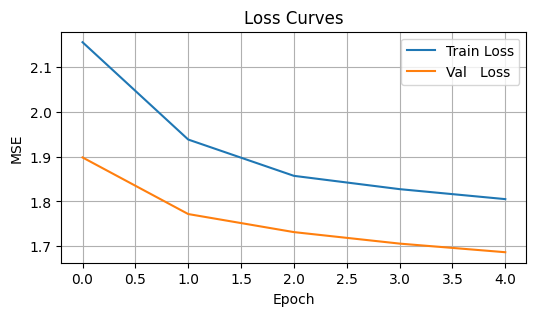

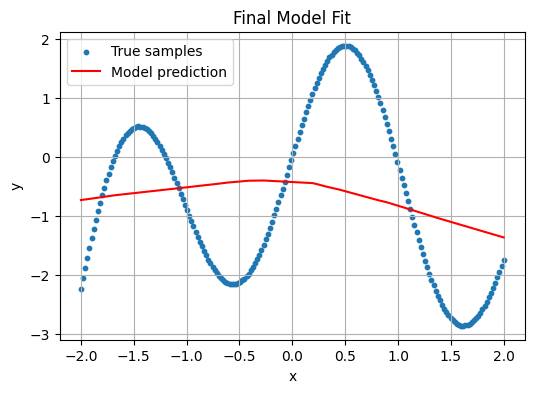

In [7]:
model_under = SimpleNet()
train_and_evaluate(model_under,
                   epochs=5,      # very few epochs
                   lr=1e-2,
                   early_stop=False)


- **Observation:** The training loss remains relatively high, and the red prediction curve is too flat or linear.

##### Illustrating Over-fitting

Increase capacity to 512 hidden units and train for 500 epochs—the model will “memorize” evrything.

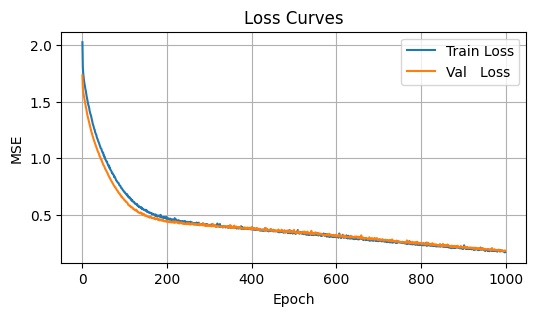

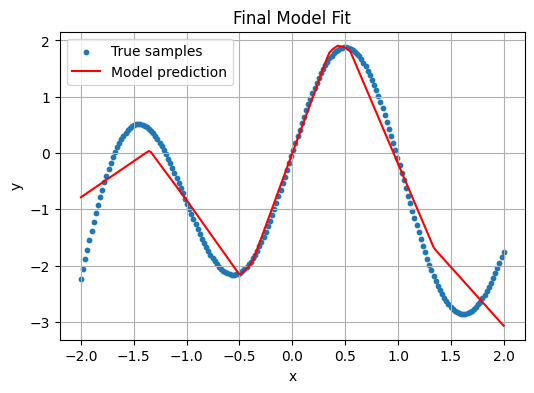

In [8]:
# Increase capacity: 1→512→1 network
class LargeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
    def forward(self, x):
        return self.net(x)

model_over = SimpleNet()
train_and_evaluate(model_over,
                   epochs=1000,
                   lr=1e-2,
                   early_stop=False)



- **Observation:** Training loss drops near zero, but the final fit oscillates wildly, chasing every noisy point. It **over-fits** the deterministic function’s high-frequency component.

#### Adding Early Stopping

Finally, we demonstrate early stopping on the large model: we’ll monitor validation loss and halt training if it fails to improve for 10 consecutive epochs.

→ Early stopping at epoch 626 (best at 606)


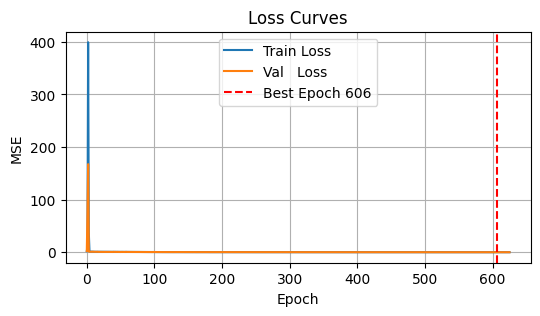

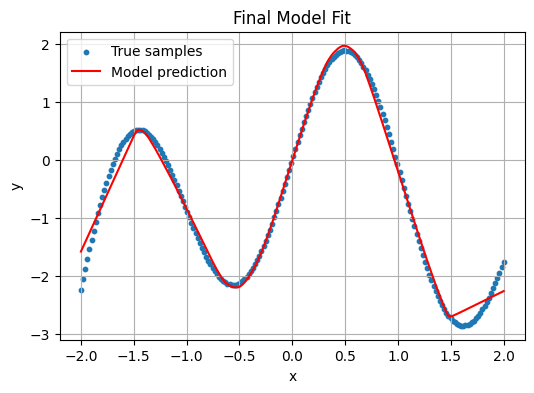

In [11]:
model_es = LargeNet()
stop_epoch = train_and_evaluate(model_es,
                                epochs=1000,
                                lr=1e-2,
                                early_stop=True,
                                patience=20)


## Finding $\pi$

### The Classic approach

Before trying with machine learning, let us first use the Monte Carlo method for estimating $\pi$. The concept is simple: imagine randomly tossing darts at a dartboard mounted to a square. Then, $\pi$ can be approximated by four times the number of darts hitting the dartboard divided by the total number of darts thrown.

> The ratio of a circle’s area ($\pi r^2$) with that to the area of a square ($4 r^2$) is $\frac{\pi}{4}$. With a unit circle, we measure the fraction $\frac{\pi}{4}$ through randomness.

Estimated value of PI: 3.18


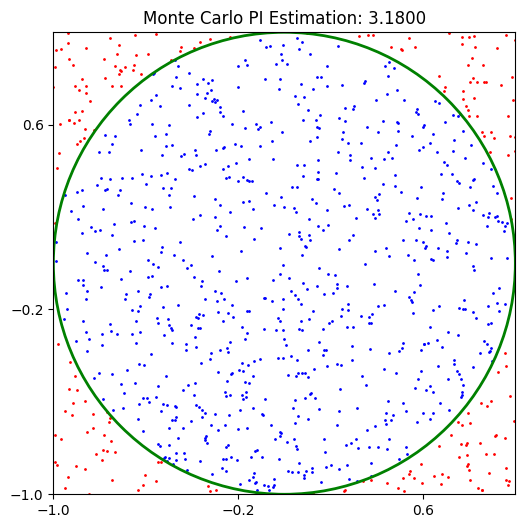

In [24]:
import matplotlib.pyplot as plt

# Number of random points
N = 1000

# Generate random points in the square [-1, 1] x [-1, 1]
x = np.random.uniform(-1, 1, N)
y = np.random.uniform(-1, 1, N)


# Determine which points are inside the circle
circled = x**2 + y**2 <= 1

# Estimate PI: fraction of points inside the circle times four
pi_val = 4 * np.sum(circled) / N

print(f"Estimated value of PI: {pi_val}")

# Plotting
plt.figure(figsize=(6,6))

# Points inside the circle in blue
plt.scatter(x[circled], y[circled], color='blue', s=1, label='Inside Circle')
# Points outside the circle in red
plt.scatter(x[~circled], y[~circled], color='red', s=1, label='Outside Circle')

# Draw the circle outline for reference
circle = plt.Circle((0, 0), 1, color='green', fill=False, linewidth=2, label='Circle')

plt.gca().add_artist(circle)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f"Monte Carlo PI Estimation: {pi_val:.4f}")
# Set ticks to be in increments of 0.8
plt.xticks(np.arange(-1, 1.1, 0.8))
plt.yticks(np.arange(-1, 1.1, 0.8))
plt.show()

### The machine Learning approach

Let us first call the usual libraries for compilation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

- **Main Strategy:** Remember that machine learning is basically learning by example. So in this case we first generate random points on the square and label them as $1$ or $0$ depending on wheather or not the points are inside the circle.

In [2]:
# Generate data
N = 100000
X_data = np.random.uniform(-1, 1, (N, 2)).astype(np.float32)
y_data = ((X_data[:, 0]**2 + X_data[:, 1]**2) <= 1).astype(np.float32) # denote the label of the point whether it is inside the circle or not

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_data)
y_tensor = torch.tensor(y_data).unsqueeze(1)

# Split into training and validation sets (80/20). For most of the cases this is the standard split
val_size = int(0.2 * N)
train_size = N - val_size
dataset = TensorDataset(X_tensor, y_tensor)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024)

- Next step is to define the network or model.

In [3]:
# Define the model

class PiNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = PiNet()


- Setting up the hyper parameters and other helpers.

In [4]:
# Training setup
criterion = nn.BCELoss() # This is the Binary Cross Entropy loss function, specially used when the target is either 0 or 1.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 200
patience = 15


# For tracking
pi_history = []
val_loss_history = []
decision_boundary_snapshots = []


In [5]:
# Helper functions for estimating PI and plot decision boundary

def estimate_pi(model, val_loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for xb, _ in val_loader:
            preds = model(xb) > 0.5
            all_preds.append(preds)
    return 4 * torch.cat(all_preds).float().mean().item()

def plot_decision_boundary(model, epoch):
    model.eval()
    grid_x, grid_y = np.meshgrid(np.linspace(-1, 1, 200), np.linspace(-1, 1, 200))
    grid_points = torch.tensor(np.c_[grid_x.ravel(), grid_y.ravel()], dtype=torch.float32)
    
    with torch.no_grad():
        preds = model(grid_points).numpy().reshape(grid_x.shape)

    plt.figure(figsize=(6, 6))
    plt.contourf(grid_x, grid_y, preds, levels=[0, 0.5, 1], alpha=0.3, colors=['red', 'blue'])
    
    X_val_np = val_dataset[:][0].numpy()
    y_val_np = val_dataset[:][1].numpy()
    plt.scatter(X_val_np[y_val_np[:, 0]==1][:, 0], X_val_np[y_val_np[:, 0]==1][:, 1], s=1, c='blue')
    plt.scatter(X_val_np[y_val_np[:, 0]==0][:, 0], X_val_np[y_val_np[:, 0]==0][:, 1], s=1, c='red')
    plt.title(f"Epoch {epoch+1}: Decision Boundary (π ≈ {pi_history[-1]:.6f})")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis('equal')
    plt.grid(True)
    plt.show()


- Let us now train the piNet

Epoch 10: Val Loss = 0.0306, π ≈ 3.164000
Epoch 20: Val Loss = 0.0231, π ≈ 3.166000
Epoch 30: Val Loss = 0.0168, π ≈ 3.142200


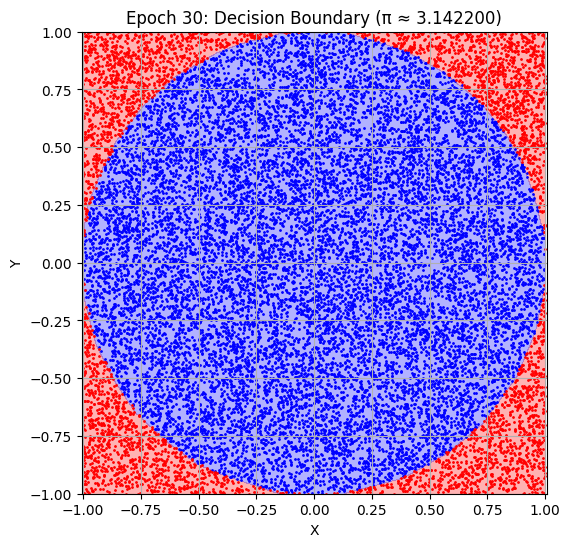

Epoch 40: Val Loss = 0.0161, π ≈ 3.151600
Epoch 50: Val Loss = 0.0170, π ≈ 3.145400
Epoch 60: Val Loss = 0.0131, π ≈ 3.136400


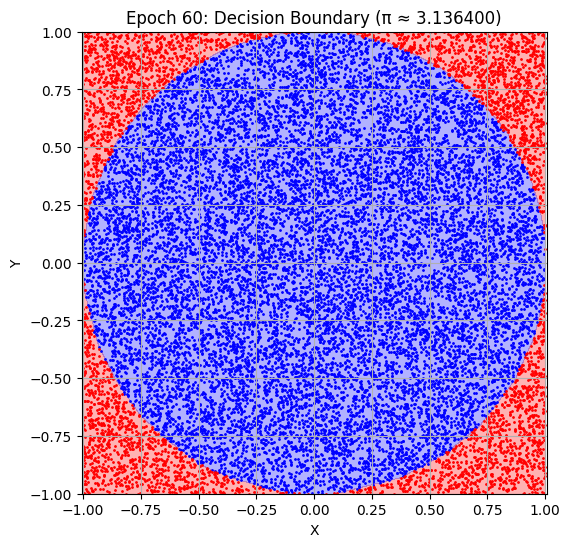

Epoch 70: Val Loss = 0.0135, π ≈ 3.149200
Epoch 80: Val Loss = 0.0106, π ≈ 3.135200
Epoch 90: Val Loss = 0.0100, π ≈ 3.136400


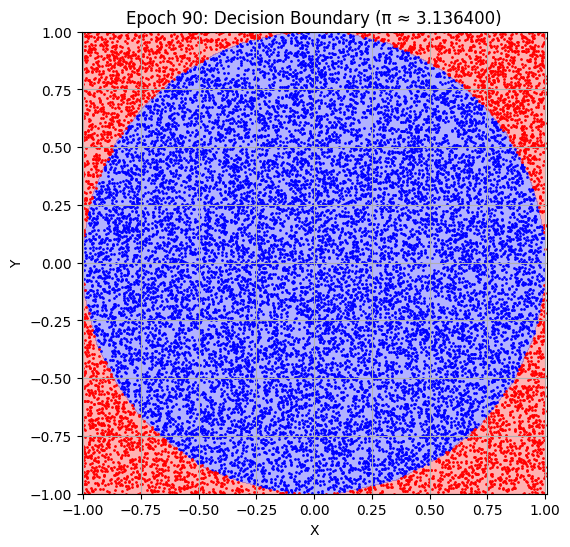

Epoch 100: Val Loss = 0.0105, π ≈ 3.130800
Early stopping!


In [6]:
# Train loop with visual updates
epochs = 300
patience = 12
best_val_loss = float('inf')
best_epoch = 0
wait = 0

for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            val_loss += criterion(model(xb), yb).item()
    val_loss /= len(val_loader)
    val_loss_history.append(val_loss)

    pi_est = estimate_pi(model, val_loader)
    pi_history.append(pi_est)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: Val Loss = {val_loss:.4f}, π ≈ {pi_est:.6f}")

    # Update best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_model_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping!")
            break

    # Plot every 10 epochs
    if (epoch + 1) % 30 == 0:
        plot_decision_boundary(model, epoch)


- **Final Plot:**  As the early stopping has occured now we can plot the best trained network, which is saved during training and see the estimate of $\pi$.


Best result at epoch 90: π ≈ 3.136400 (val_loss: 0.009970)


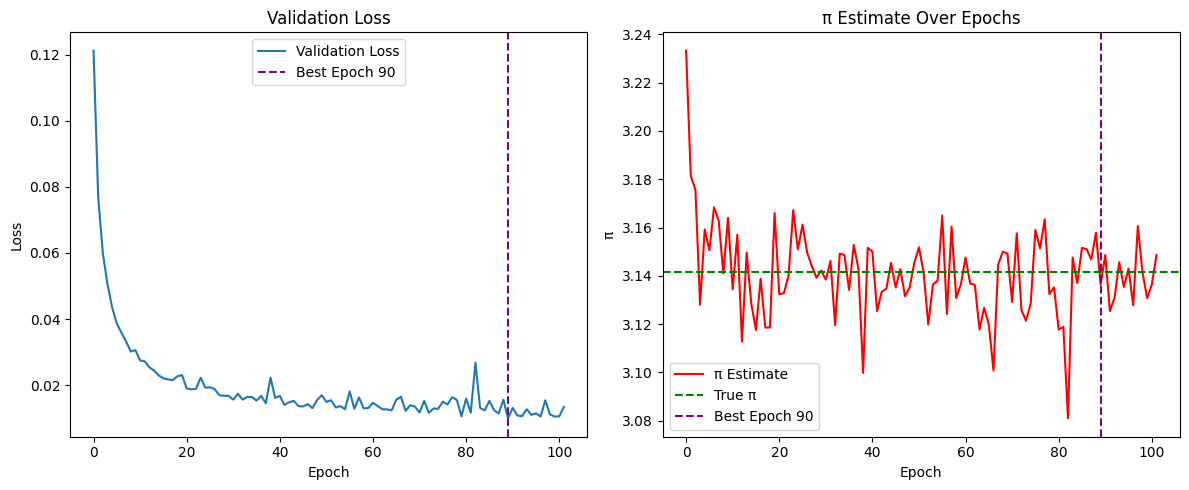

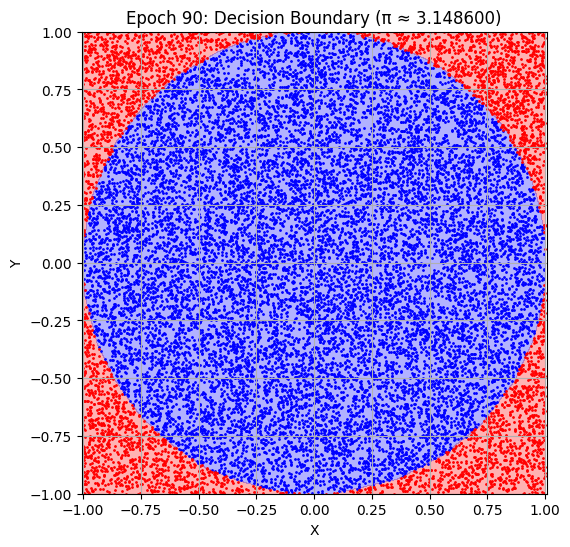

In [7]:
# Final plots after training
model.load_state_dict(best_model_state) # This is the best model saved by the early stopping 
print(f"\nBest result at epoch {best_epoch+1}: π ≈ {pi_history[best_epoch]:.6f} (val_loss: {val_loss_history[best_epoch]:.6f})")

# Plot loss and π estimate history
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(val_loss_history, label="Validation Loss")
plt.axvline(x=best_epoch, color='purple', linestyle='--', label=f'Best Epoch {best_epoch+1}')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Validation Loss")

# π Estimate
plt.subplot(1, 2, 2)
plt.plot(pi_history, color='red', label="π Estimate")
plt.axhline(y=np.pi, color='green', linestyle='--', label="True π")
plt.axvline(x=best_epoch, color='purple', linestyle='--', label=f'Best Epoch {best_epoch+1}')
plt.xlabel("Epoch")
plt.ylabel("π")
plt.legend()
plt.title("π Estimate Over Epochs")

plt.tight_layout()
plt.show()

# Final decision boundary
plot_decision_boundary(model, best_epoch)


## What Next?

So far we have only discussed about **Supervised models**. Supervised learning involves training a model on a labeled dataset, meaning each input comes with the correct output. The goal is for the model to learn to predict these labels on new, unseen data.

- **Pros:**
    - High accuracy when enough labeled data is available.

    - Predictable performance and easier to evaluate.

    - Well-supported with mature libraries.

- **Cons:**
    - Requires large, clean labeled datasets (can be expensive/time-consuming to produce).

    - May overfit if not enough data or too complex a model.

#### Unsupervised models
Unsupervised learning works with unlabeled data. The model tries to discover hidden patterns or structures in the data.

- **Examples:** Clustering customers into groups based on purchasing behavior — the model finds structure without being told what group each customer belongs to. Another interesting example is of the **autoencoder**.

- **Pros:**
    - Works without labeled data.

    - Helps with data exploration, dimensionality reduction, and pattern discovery.

- **Cons:**
    - Hard to evaluate the model (no ground truth).

    - May find patterns that are not meaningful or useful.

    - Often requires strong assumptions about data structure.

#### Reinforcement Learning
Reinforcement learning is based on an agent interacting with an environment. The agent learns through trial and error, receiving rewards or penalties for actions it takes.

- **Example:** Training a robot to walk or a program to play chess — it learns strategies that maximize short or long-term reward.

- **Pros:**
    - Excellent for sequential decision-making and control tasks.

    - Learns directly from interaction without needing labeled datasets.

- **Cons:**
    - Often slow and computationally expensive.

    - May require a lot of exploration or simulation before learning effectively.

    - Sensitive to the choice of reward structure.